In [1]:
## Unzip the contents of results/outputs.zip
import zipfile
import os
from aalchem.config import paths
import pandas as pd 

def unzip_to_self_directory(zip_file_path):
    zip_dir = os.path.dirname(zip_file_path)
    extract_dir = os.path.join(zip_dir)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted '{zip_file_path}' to '{extract_dir}'")

unzip_to_self_directory(paths.RESULTS / "transition_model.zip")

Extracted '/Users/amac/git/phd/AAL-Chem-anon/results/transition_model.zip' to '/Users/amac/git/phd/AAL-Chem-anon/results'


In [2]:
proprietary_models = {
    'gemini_2_5_flash_thinking': 'Gemini 2.5 Flash',
    'gpt_5': 'GPT-5',
    'claude_sonnet_4_20250514': 'Claude Sonnet 4',
    'gemini_2_5_pro': 'Gemini 2.5 Pro',
}

open_source_models = { 
    'ether0': 'Ether0', 
    'qwen3-4B-thinking-2507': 'Qwen3-4B', 
    'qwen3-30B-A3B-thinking-2507': 'Qwen3-30B', 
    'qwen3-235B-A22B-instruct-2507-FP8': 'Qwen3-235B',
    'qwen3-235B-A22B-thinking-2507-FP8': 'Qwen3-235B',
    'redhat-ai-deepseek-r1-0528-quantized_w4a16': 'DeepSeek-R1-670B', 
}

ablation_models = {
    ## Ablation
    'gemini_2_5_pro_short_no_ex': 'Gemini 2.5 Pro\n(short no examples)',
    'gemini_2_5_pro_no_ex': 'Gemini 2.5 Pro\n(detailed no examples)',
    'gemini_2_5_pro_short_with_ex': 'Gemini 2.5 Pro\n(short with examples)',
}

## Models ordered for plotting
all_models = {    
    'qwen3-4B-thinking-2507': 'Qwen3-4B', 
    'qwen3-30B-A3B-thinking-2507': 'Qwen3-30B', 
    'gemini_2_5_flash_thinking': 'Gemini 2.5 Flash',
    'qwen3-235B-A22B-thinking-2507-FP8': 'Qwen3-235B',
    'redhat-ai-deepseek-r1-0528-quantized_w4a16': 'DeepSeek-R1-670B', 
    'claude_sonnet_4_20250514': 'Claude Sonnet 4',
    'gpt_5': 'GPT-5',
    'gemini_2_5_pro': 'Gemini-2.5-Pro',
    ## Excluded models
    # 'gemini_2_5_flash': 'Gemini-2.5-Flash',
    # 'ether0': 'Ether0', 
    # 'position_qwen3-235B-A22B-instruct-2507-FP8': 'Qwen3-235B',
}

In [ ]:
from aalchem.vllm.transition_model.evaluation.get_results import get_transition_model_results
### Calculate statistics for each model

for k, v in proprietary_models.items():
    results = get_transition_model_results(
        model_name=k,
        json_dir='jsons',
        proprietary=True
    )

for k, v in open_source_models.items():
    results = get_transition_model_results(
        model_name=k,
        json_dir='jsons',
        proprietary=False
    ) 

for k, v in ablation_models.items():
    results = get_transition_model_results(
        model_name=f'ablation/{k}',
        json_dir='jsons',
        proprietary=True
    )

In [4]:
# Load CSV files

datasets = {}
dataset_list = []
for k, v in all_models.items():
    print(k, v)
    df_path = os.path.join(paths.RESULTS, 'transition_model', k, 'aggregated_statistics.csv')
    df = pd.read_csv(df_path)
    datasets[v] = df
    dataset_list.append(df)
print(datasets.keys())

## Load ablation results
for k, v in ablation_models.items():
    df_path = os.path.join(paths.RESULTS, 'transition_model', f'ablation/{k}', 'aggregated_statistics.csv')
    df = pd.read_csv(df_path)
    datasets[v] = df

qwen3-4B-thinking-2507 Qwen3-4B
qwen3-30B-A3B-thinking-2507 Qwen3-30B
gemini_2_5_flash_thinking Gemini 2.5 Flash
qwen3-235B-A22B-thinking-2507-FP8 Qwen3-235B
redhat-ai-deepseek-r1-0528-quantized_w4a16 DeepSeek-R1-670B
claude_sonnet_4_20250514 Claude Sonnet 4
gpt_5 GPT-5
gemini_2_5_pro Gemini-2.5-Pro
dict_keys(['Qwen3-4B', 'Qwen3-30B', 'Gemini 2.5 Flash', 'Qwen3-235B', 'DeepSeek-R1-670B', 'Claude Sonnet 4', 'GPT-5', 'Gemini-2.5-Pro'])


In [5]:
def calculate_balanced_accuracy(df, column, include_other_reaction = False):
    if not include_other_reaction:
        reaction_df = df[df['category'].str.startswith('reaction_')]
    else:
        reaction_df = df[df['category'].str.startswith('reaction_') | (df['category'] == 'other_reaction')]
    balanced_accuracy = reaction_df[column].mean()
    return balanced_accuracy

# Test the balanced accuracy function
print("Testing balanced accuracy calculation:")
for i, (model_name, df) in enumerate(datasets.items()):
    balanced_acc = calculate_balanced_accuracy(df, 'either_accuracy_with_stereochemistry')
    balanced_acc_with_other_reaction = calculate_balanced_accuracy(df, 'either_accuracy_with_stereochemistry', include_other_reaction=True)
    non_other_reaction_acc = df[df['category'] == 'non_other_reaction']['either_accuracy_with_stereochemistry'].iloc[0]
    print(f"{model_name}:")
    print(f"  Balanced (with other reaction): {balanced_acc_with_other_reaction:.3f}")
    print(f"  Balanced (reaction-level without other reaction): {balanced_acc:.3f}")
    print(f"  Non-other reaction without balancing: {non_other_reaction_acc:.3f}")
    print(f"  Difference: {balanced_acc - non_other_reaction_acc:.3f}")
    print()

Testing balanced accuracy calculation:
Qwen3-4B:
  Balanced (with other reaction): 0.125
  Balanced (reaction-level without other reaction): 0.126
  Non-other reaction without balancing: 0.142
  Difference: -0.016

Qwen3-30B:
  Balanced (with other reaction): 0.287
  Balanced (reaction-level without other reaction): 0.288
  Non-other reaction without balancing: 0.304
  Difference: -0.015

Gemini 2.5 Flash:
  Balanced (with other reaction): 0.517
  Balanced (reaction-level without other reaction): 0.519
  Non-other reaction without balancing: 0.549
  Difference: -0.030

Qwen3-235B:
  Balanced (with other reaction): 0.653
  Balanced (reaction-level without other reaction): 0.657
  Non-other reaction without balancing: 0.679
  Difference: -0.022

DeepSeek-R1-670B:
  Balanced (with other reaction): 0.699
  Balanced (reaction-level without other reaction): 0.702
  Non-other reaction without balancing: 0.747
  Difference: -0.045

Claude Sonnet 4:
  Balanced (with other reaction): 0.740
  Bal

In [6]:
pdf_save_folder_path = os.path.join(paths.PLOTS, 'transition_model')
os.makedirs(pdf_save_folder_path, exist_ok=True)

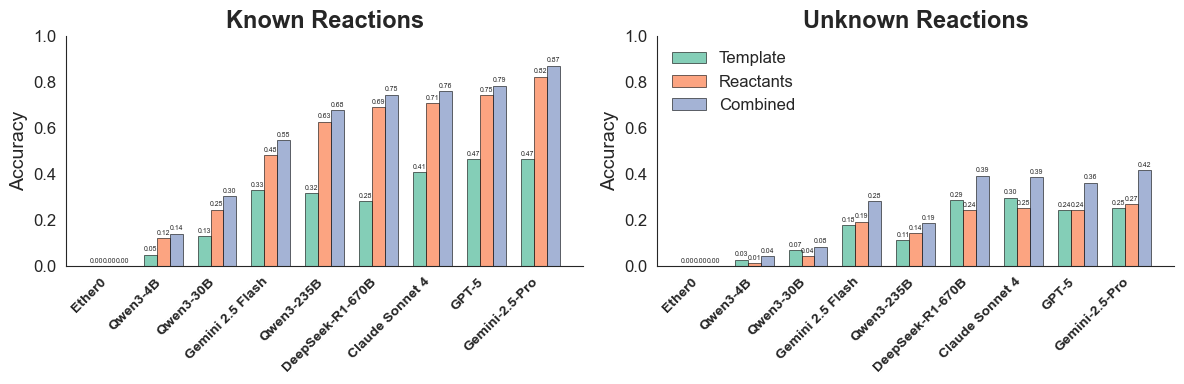

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set clean style
sns.set_style("white")
plt.rcParams.update({'font.size': 12})

# Define models and datasets
models = [k for k, v in datasets.items() if k not in ablation_models.values()]
data = [v for k, v in datasets.items() if k not in ablation_models.values()]
categories = ['non_other_reaction', 'other_reaction']
category_titles = ['Known Reactions', 'Unknown Reactions']

# Create 3 subplots side by side

# Layout - 2 rows, 2 columns
# First row: Overall (spanning both columns)
# Second row: Known Reactions | Unknown Reactions


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

models.insert(0, 'Ether0')
# Prepare data for all three plots
for cat_idx, (category, title) in enumerate(zip(categories, category_titles)):
    ax = axes[cat_idx]
    
    # Extract metrics for current category
    template_acc = [df[df['category'] == category]['template_accuracy_with_stereochemistry'].iloc[0] for df in data]
    reactants_acc = [df[df['category'] == category]['reactants_accuracy_with_stereochemistry'].iloc[0] for df in data]
    either_acc = [df[df['category'] == category]['either_accuracy_with_stereochemistry'].iloc[0] for df in data]

    ## Add ether0 to the front of the list with zeroes
    template_acc.insert(int(0), int(0))
    reactants_acc.insert(int(0), int(0))
    either_acc.insert(int(0), int(0))
    
    # Create grouped bar plot
    x = range(len(models))
    width = 0.24
    ## color from Set2 palette
    ax.bar([i - width for i in x], template_acc, width, label='Template Accuracy', alpha=0.8, color=sns.color_palette("Set2")[0], linewidth=0.5, edgecolor='black') 
    ax.bar(x, reactants_acc, width, label='Reactants Accuracy', alpha=0.8, color=sns.color_palette("Set2")[1], linewidth=0.5, edgecolor='black')
    ax.bar([i + width for i in x], either_acc, width, label='Combined Accuracy', alpha=0.8, color=sns.color_palette("Set2")[2], linewidth=0.5, edgecolor='black')
    
    # Customize subplot
    # ax.set_xlabel('Models', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title(title, fontsize=17, fontweight='bold')
    # Ticks with notches
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='center', fontsize=10, fontweight='bold', horizontalalignment='right')
    ax.set_ylim(0, 1)
    # Add
    #ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (temp, react, either) in enumerate(zip(template_acc, reactants_acc, either_acc)):
        size = 5
        ax.text(i - width, temp + 0.01, f'{temp:.2f}', ha='center', va='bottom', fontsize=size)
        ax.text(i, react + 0.01, f'{react:.2f}', ha='center', va='bottom', fontsize=size)
        ax.text(i + width, either + 0.01, f'{either:.2f}', ha='center', va='bottom', fontsize=size)
    
    # Only show legend on the first subplot
    if cat_idx == 1:
        legend = ax.legend(['Template', 'Reactants', 'Combined'], loc='upper left', fontsize=12, frameon=False)

# Remove top and right spines
for ax in axes:
    sns.despine(ax=ax)

plt.tight_layout()
# plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.savefig(f'{pdf_save_folder_path}/transition_accuracy_known_unknown.pdf', dpi=300, bbox_inches='tight')
plt.show()

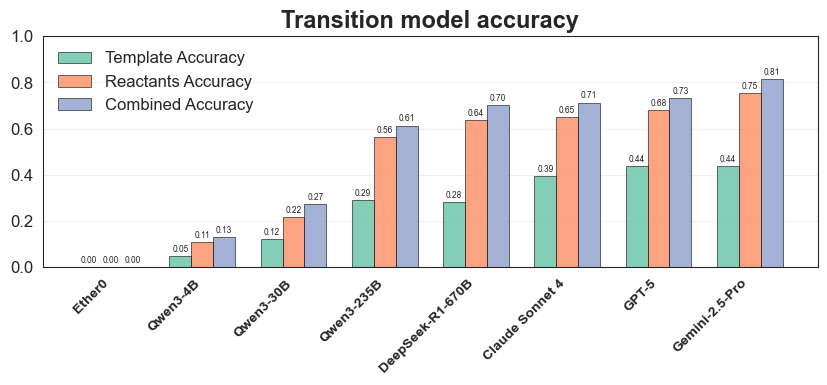

In [16]:
# Same plot but for 'overall' category

from tokenize import PlainToken


plt.figure(figsize=(10, 3))

template_acc = [df[df['category'] == 'overall']['template_accuracy_with_stereochemistry'].iloc[0] for df in data]
reactants_acc = [df[df['category'] == 'overall']['reactants_accuracy_with_stereochemistry'].iloc[0] for df in data]
either_acc = [df[df['category'] == 'overall']['either_accuracy_with_stereochemistry'].iloc[0] for df in data]

## Add ether0 to the front of the list with zeroes
template_acc.insert(int(0), int(0))
reactants_acc.insert(int(0), int(0))
either_acc.insert(int(0), int(0))


# Create grouped bar plot
x = range(len(models))
width = 0.24

plt.bar([i - width for i in x], template_acc, width, label='Template Accuracy', alpha=0.8, color=sns.color_palette("Set2")[0], linewidth=0.5, edgecolor='black') 
plt.bar(x, reactants_acc, width, label='Reactants Accuracy', alpha=0.8, color=sns.color_palette("Set2")[1], linewidth=0.5, edgecolor='black')
plt.bar([i + width for i in x], either_acc, width, label='Combined Accuracy', alpha=0.8, color=sns.color_palette("Set2")[2], linewidth=0.5, edgecolor='black')

# Customize subplot
# ax.set_xlabel('Models', fontsize=14)
# plt.ylabel('Accuracy', fontsize=14)
plt.title("Transition model accuracy", fontsize=17, fontweight='bold')

# Ticks with notches
plt.xticks(x, models, rotation=45, ha='center', fontsize=10, fontweight='bold', horizontalalignment='right')
plt.ylim(0, 1)
# Add
#ax.grid(axis='y', alpha=0.3)
## Add numbers on bars
for i, (temp, react, either) in enumerate(zip(template_acc, reactants_acc, either_acc)):
    size = 6
    plt.text(i - width, temp + 0.01, f'{temp:.2f}', ha='center', va='bottom', fontsize=size)
    plt.text(i, react + 0.01, f'{react:.2f}', ha='center', va='bottom', fontsize=size)
    plt.text(i + width, either + 0.01, f'{either:.2f}', ha='center', va='bottom', fontsize=size)
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.grid(axis='y', alpha=0.3)
plt.savefig(f'{pdf_save_folder_path}/accuracy_comparison_overall.pdf', dpi=300, bbox_inches='tight')
plt.show()


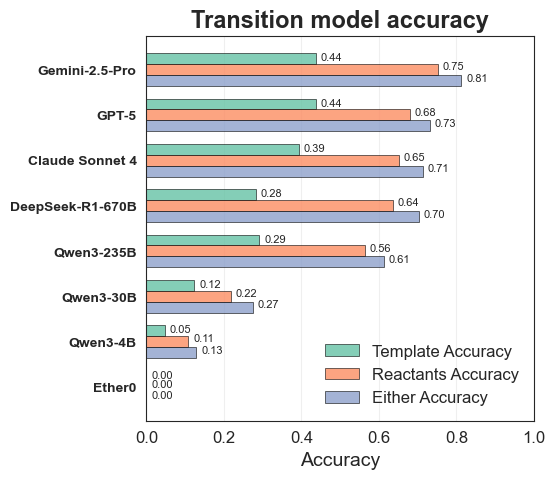

In [17]:
## Same plot but horizontal
plt.figure(figsize=(5, 5))

# Create grouped bar plot
x = range(len(models))
width = 0.24    

plt.barh([x + width for x in x], template_acc, width, label='Template Accuracy', alpha=0.8, color=sns.color_palette("Set2")[0], linewidth=0.5, edgecolor='black') 
plt.barh([x for x in x], reactants_acc, width, label='Reactants Accuracy', alpha=0.8, color=sns.color_palette("Set2")[1], linewidth=0.5, edgecolor='black')
plt.barh([x - width for x in x], either_acc, width, label='Either Accuracy', alpha=0.8, color=sns.color_palette("Set2")[2], linewidth=0.5, edgecolor='black')

plt.xlabel('Accuracy', fontsize=14)
plt.title("Transition model accuracy", fontsize=17, fontweight='bold')

plt.yticks(x, models, rotation=0, ha='center', fontsize=10, fontweight='bold', horizontalalignment='right')
plt.xlim(0, 1)

## Add numbers on bars (adjusted for horizontal plot)
for i, (temp, react, either) in enumerate(zip(template_acc, reactants_acc, either_acc)):
    size = 8
    plt.text(temp + 0.04, i+0.15, f'{temp:.2f}', ha='center', va='bottom', fontsize=size)
    plt.text(react + 0.04, i-0.05, f'{react:.2f}', ha='center', va='bottom', fontsize=size)
    plt.text(either + 0.04, i-0.3, f'{either:.2f}', ha='center', va='bottom', fontsize=size)

plt.grid(axis='x', alpha=0.3)
plt.legend(loc='lower right', fontsize=12, frameon=False)
plt.show()

    

## Ablation

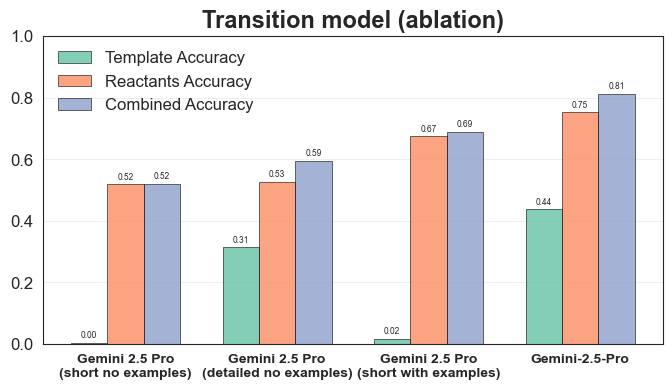

In [18]:
# Define models and datasets
models = [k for k, v in datasets.items() if k in ablation_models.values()]
data = [v for k, v in datasets.items() if k in ablation_models.values()]

## Add Gemini 2.5 Pro (2) to the list
models.append(all_models['gemini_2_5_pro'])
data.append(datasets[all_models['gemini_2_5_pro']])


plt.figure(figsize=(8, 4))

template_acc = [df[df['category'] == 'overall']['template_accuracy_with_stereochemistry'].iloc[0] for df in data]
reactants_acc = [df[df['category'] == 'overall']['reactants_accuracy_with_stereochemistry'].iloc[0] for df in data]
either_acc = [df[df['category'] == 'overall']['either_accuracy_with_stereochemistry'].iloc[0] for df in data]

# Create grouped bar plot
x = range(len(models))
width = 0.24

plt.bar([i - width for i in x], template_acc, width, label='Template Accuracy', alpha=0.8, color=sns.color_palette("Set2")[0], linewidth=0.5, edgecolor='black') 
plt.bar(x, reactants_acc, width, label='Reactants Accuracy', alpha=0.8, color=sns.color_palette("Set2")[1], linewidth=0.5, edgecolor='black')
plt.bar([i + width for i in x], either_acc, width, label='Combined Accuracy', alpha=0.8, color=sns.color_palette("Set2")[2], linewidth=0.5, edgecolor='black')

# Customize subplot
# ax.set_xlabel('Models', fontsize=14)
# plt.ylabel('Accuracy', fontsize=14)
plt.title("Transition model (ablation)", fontsize=17, fontweight='bold')

# Ticks with notches
plt.xticks(x, models, rotation=0, ha='center', fontsize=10, fontweight='bold')
plt.ylim(0, 1)
# Add
#ax.grid(axis='y', alpha=0.3)
## Add numbers on bars
for i, (temp, react, either) in enumerate(zip(template_acc, reactants_acc, either_acc)):
    size = 6
    plt.text(i - width, temp + 0.01, f'{temp:.2f}', ha='center', va='bottom', fontsize=size)
    plt.text(i, react + 0.01, f'{react:.2f}', ha='center', va='bottom', fontsize=size)
    plt.text(i + width, either + 0.01, f'{either:.2f}', ha='center', va='bottom', fontsize=size)
plt.legend(loc='upper left', fontsize=12, frameon=False)
plt.grid(axis='y', alpha=0.3)
plt.savefig(f'{pdf_save_folder_path}/transition_ablation.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
def get_metric_from_df(model_name, metric_name):
    df = datasets[model_name]
    return df[df['category'] == 'overall'][metric_name].iloc[0]

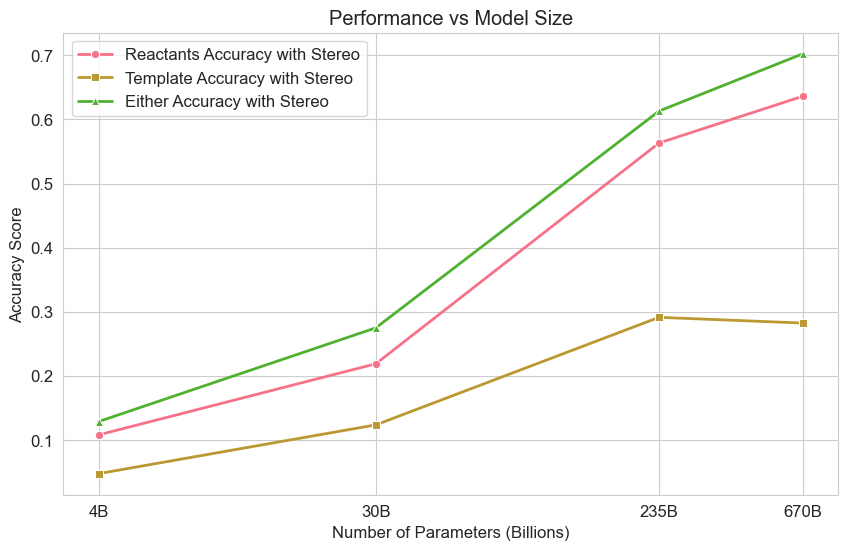

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Extract parameter counts (in billions) and performance metrics
models = ['Qwen3-4B', 'Qwen3-30B', 'Qwen3-235B', 'DeepSeek-R1-670B']
param_counts = [4, 30, 235, 670]  # in billions

# Extract performance metrics
reactants_accuracy = [get_metric_from_df(model, 'reactants_accuracy_with_stereochemistry') for model in models]
template_accuracy = [get_metric_from_df(model, 'template_accuracy_with_stereochemistry') for model in models]
either_accuracy = [get_metric_from_df(model, 'either_accuracy_with_stereochemistry') for model in models]

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=param_counts, y=reactants_accuracy, marker='o', label='Reactants Accuracy with Stereo', linewidth=2)
sns.lineplot(x=param_counts, y=template_accuracy, marker='s', label='Template Accuracy with Stereo', linewidth=2)
sns.lineplot(x=param_counts, y=either_accuracy, marker='^', label='Either Accuracy with Stereo', linewidth=2)

plt.xlabel('Number of Parameters (Billions)')
plt.ylabel('Accuracy Score')
plt.title('Performance vs Model Size')
plt.xscale('log')
plt.xticks(param_counts, ['4B', '30B', '235B', '670B'])
plt.legend()
plt.savefig(os.path.join(pdf_save_folder_path, 'overall_performance_vs_model_size.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [29]:
## Performance per Class

transition_result = os.path.join(paths.RESULTS, 'transition_model', 'gemini_2_5_pro', 'analyze_results.csv')
transition_result = pd.read_csv(transition_result)
transition_result

,at_least_one_valid_non_template_reactant_pair_generated,template_match_found_without_stereochemistry,template_match_found_with_stereochemistry,match_found_without_stereochemistry,match_found_with_stereochemistry,number_of_reactant_predictions_created,number_of_reactants_per_prediction,number_of_templates_created,number_of_non_templates_created,number_of_valid_predictions_without_templates,number_of_invalid_predictions_out_templates,failed_json_parsing,row_index,ground_truth_canonicalized_product,ground_truth_rxn_insight_name,ground_truth_rxn_insight_class,ground_truth_reaction_examples,ground_truth_number_of_reaction_examples
0,True,True,True,True,True,5,"[2, 2, 2, 2, 2]",1,4,3,1,False,0,[CH2:1]=[CH:2][CH2:3][N:4]([CH2:5][CH:6]([c:7]...,N-alkylation of secondary amines with alkyl ha...,Heteroatom Alkylation and Arylation,['[CH2:1]=[CH:2][CH2:3][N:4]([CH2:5][CH:6]([c:...,5
1,True,True,True,True,True,4,"[2, 2, 2, 2]",1,3,3,0,False,1,[O:1]=[C:2]([O:3][CH2:4][c:5]1[cH:6][cH:7][c:8...,N-alkylation of secondary amines with alkyl ha...,Protection,['[CH2:1]=[CH:2][CH2:3][N:4]([CH2:5][CH:6]([c:...,5
2,True,True,True,True,True,5,"[2, 2, 2, 2, 2]",1,4,4,0,False,2,[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]([C:7]([c:8...,N-alkylation of secondary amines with alkyl ha...,Heteroatom Alkylation and Arylation,['[CH2:1]=[CH:2][CH2:3][N:4]([CH2:5][CH:6]([c:...,5
3,True,True,True,True,False,4,"[2, 2, 2, 2]",1,3,3,0,False,3,[CH3:1][c:2]1[n:3][c:4]2[cH:5][c:6]([O:7][CH2:...,N-alkylation of secondary amines with alkyl ha...,Heteroatom Alkylation and Arylation,['[CH2:1]=[CH:2][CH2:3][N:4]([CH2:5][CH:6]([c:...,5
4,True,True,True,True,True,5,"[2, 2, 2, 2, 2]",1,4,3,1,False,4,[CH3:1][N:2]1[C:3](=[O:4])[c:5]2[c:6]([c:7]3[c...,N-alkylation of secondary amines with alkyl ha...,Heteroatom Alkylation and Arylation,['[CH2:1]=[CH:2][CH2:3][N:4]([CH2:5][CH:6]([c:...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,True,True,True,True,True,8,"[2, 2, 2, 2, 2, 2, 2, 2]",1,7,7,0,False,507,[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7...,OtherReaction,Heteroatom Alkylation and Arylation,[],0
508,True,True,False,True,False,9,"[2, 2, 2, 2, 2, 2, 2, 2, 2]",1,8,8,0,False,508,[CH3:1][N:2]([C:3](=[O:4])[O:5][C:6]([CH3:7])(...,OtherReaction,Miscellaneous,[],0
509,False,False,False,False,False,6,"[2, 2, 2, 2, 2, 2]",1,5,4,1,False,509,[CH3:1][C:2]1([CH3:3])[CH2:4][N:5]([CH2:6][c:7...,OtherReaction,Protection,[],0
510,True,False,False,False,False,5,"[2, 2, 2, 2, 2]",0,5,3,2,False,510,[CH3:1][CH2:2][CH2:3][CH2:4][c:5]1[cH:6][c:7](...,OtherReaction,Aromatic Heterocycle Formation,[],0


In [30]:
unique_reaction_classes = transition_result["ground_truth_rxn_insight_class"].unique()
unique_reaction_classes = sorted(unique_reaction_classes)
unique_reaction_classes

['Acylation',
 'Aromatic Heterocycle Formation',
 'C-C Coupling',
 'Deprotection',
 'Functional Group Addition',
 'Functional Group Interconversion',
 'Heteroatom Alkylation and Arylation',
 'Miscellaneous',
 'Oxidation',
 'Protection',
 'Reduction']

In [31]:
unique_reaction_names = transition_result["ground_truth_rxn_insight_name"].unique()
unique_reaction_names = sorted(unique_reaction_names)
unique_reaction_names

['Acetal hydrolysis to aldehyde',
 'Acylation of Nitrogen Nucleophiles by Acyl/Thioacyl/Carbamoyl Halides and Analogs_OS',
 'Acylation of Nitrogen Nucleophiles by Carboxylic Acids',
 'Addition of primary amines to aldehydes/thiocarbonyls',
 'Addition of primary amines to ketones/thiocarbonyls',
 'Alcohol deprotection from silyl ethers',
 'Alcohol to ether',
 'Aldol condensation',
 'Alkylation of amines',
 'Amine and thiophosgene to isothiocyanate',
 'Aminolysis of esters',
 'Appel reaction',
 'Aromatic dehalogenation',
 'Azide to amine reduction (Staudinger)',
 'Boc amine deprotection',
 'Boc amine protection (ethyl Boc)',
 'Boc amine protection of secondary amine',
 'Boc amine protection with Boc anhydride',
 'Bouveault aldehyde synthesis',
 'Buchwald-Hartwig/Ullmann-Goldberg/N-arylation primary amine',
 'Buchwald-Hartwig/Ullmann-Goldberg/N-arylation secondary amine',
 'Carboxylic acid to amide conversion',
 'Carboxylic acid with primary amine to amide',
 'Chan-Lam etherification',
 '

In [32]:
all_models

{'qwen3-4B-thinking-2507': 'Qwen3-4B',
 'qwen3-30B-A3B-thinking-2507': 'Qwen3-30B',
 'qwen3-235B-A22B-thinking-2507-FP8': 'Qwen3-235B',
 'redhat-ai-deepseek-r1-0528-quantized_w4a16': 'DeepSeek-R1-670B',
 'claude_sonnet_4_20250514': 'Claude Sonnet 4',
 'gpt_5': 'GPT-5',
 'gemini_2_5_pro': 'Gemini-2.5-Pro'}

# PER CLASS PERFORMANCE

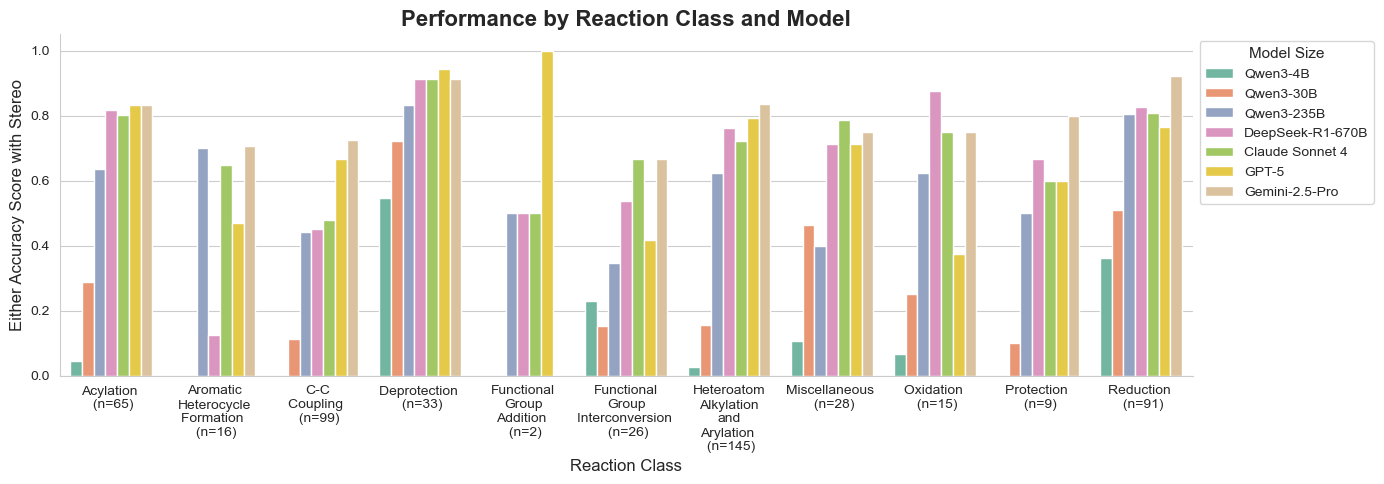

In [34]:
# Create a grouped bar plot for performance by unique reaction classes
# First, prepare the data in a format suitable for seaborn
plot_data = []
# plot_da = = [k for k, v in datasets.items() if k not in ablation_models.values()]
plot_datasets = {k:v for k, v in datasets.items() if k not in ablation_models.values()}

for rxn_class in unique_reaction_classes:
    category_name = f"class_{rxn_class}"
    
    for i, (model_name, df) in enumerate(plot_datasets.items()):
        class_row = df[df['category'] == category_name]
        if not class_row.empty:
            plot_data.append({
                'Reaction Class': rxn_class,
                'Model Size': model_name,
                'Either Accuracy Score': class_row['either_accuracy_with_stereochemistry'].iloc[0]
            })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Get sample counts for each reaction class from the first model's data
class_sample_counts = {}
qwen3_4b = datasets['Qwen3-4B']
for rxn_class in unique_reaction_classes:
    category_name = f"class_{rxn_class}"
    class_row = qwen3_4b[qwen3_4b['category'] == category_name]
    if not class_row.empty:
        sample_count = class_row['total_samples'].iloc[0]
        class_sample_counts[rxn_class] = sample_count

# Create x-tick labels with sample counts and line breaks
x_labels_with_counts = []
for rxn_class in unique_reaction_classes:
    class_name_with_breaks = rxn_class.replace(' ', '\n')
    sample_count = class_sample_counts.get(rxn_class, 0)
    x_labels_with_counts.append(f"{class_name_with_breaks} \n (n={sample_count})")

# Create the grouped bar plot
plt.figure(figsize=(14, 5))
sns.barplot(data=plot_df, x='Reaction Class', y='Either Accuracy Score', hue='Model Size', palette='Set2')

plt.xlabel('Reaction Class', fontsize=12)
plt.ylabel('Either Accuracy Score with Stereo', fontsize=12)
plt.title('Performance by Reaction Class and Model', fontsize=16, fontweight='bold')
plt.xticks(range(len(unique_reaction_classes)), x_labels_with_counts, rotation=0, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Model Size', fontsize=10, title_fontsize=11, loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(pdf_save_folder_path, 'performance_by_reaction_class.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# REACTION LEVEL

In [35]:
# Simplified Heatmap without reaction classes - just sort by reaction name
plt.figure(figsize=(12, 20))  # A4-like proportions

# Create simple plot_df for reactions without class complications
simple_plot_data = []

for rxn_name in unique_reaction_names:
    if rxn_name == "OtherReaction":
        category_name = "other_reaction"
    else:
        category_name = f"reaction_{rxn_name}"
    
    for i, (df, model_name) in enumerate(zip(dataset_list, all_models.values())):
        reaction_row = df[df['category'] == category_name]
        if not reaction_row.empty:
            simple_plot_data.append({
                'Reaction Name': rxn_name,
                'Model Size': model_name,
                'Either Accuracy Score': reaction_row['either_accuracy_with_stereochemistry'].iloc[0]
            })

simple_plot_df = pd.DataFrame(simple_plot_data)

# Prepare data for heatmap with proper ordering
heatmap_data = simple_plot_df.pivot_table(index='Reaction Name', columns='Model Size', values='Either Accuracy Score')
heatmap_data

Model Size,Claude Sonnet 4,DeepSeek-R1-670B,GPT-5,Gemini-2.5-Pro,Qwen3-235B,Qwen3-30B,Qwen3-4B
Reaction Name,,,,,,,
Acetal hydrolysis to aldehyde,1.000000,0.75,1.000000,1.0,0.50,0.75,0.00
Acylation of Nitrogen Nucleophiles by Acyl/Thioacyl/Carbamoyl Halides and Analogs_OS,1.000000,1.00,1.000000,1.0,1.00,0.40,0.00
Acylation of Nitrogen Nucleophiles by Carboxylic Acids,0.800000,1.00,1.000000,0.8,0.40,0.20,0.00
Addition of primary amines to aldehydes/thiocarbonyls,0.666667,1.00,0.333333,1.0,0.80,0.40,0.00
Addition of primary amines to ketones/thiocarbonyls,1.000000,0.75,1.000000,1.0,1.00,0.50,0.25
...,...,...,...,...,...,...,...
oxa-Michael addition,1.000000,1.00,1.000000,1.0,1.00,0.00,0.00
reductive amination,0.400000,0.60,0.600000,0.6,0.80,0.00,0.00
thiazole,0.600000,0.20,0.200000,0.8,1.00,0.00,0.00


<Figure size 1200x2000 with 0 Axes>

In [36]:
# Debug: Check why assertion is failing
print(f"Number of unique reaction names: {len(unique_reaction_names)}")
print(f"Number of rows in simple_plot_df: {len(simple_plot_df)}")
print(f"Number of unique reactions in simple_plot_df: {simple_plot_df['Reaction Name'].nunique()}")
print(f"Heatmap data shape: {heatmap_data.shape}")

# Find missing reactions
reactions_in_data = set(simple_plot_df['Reaction Name'].unique())
missing_reactions = set(unique_reaction_names) - reactions_in_data

print(f"\nMissing reactions (not found in performance data): {len(missing_reactions)}")
if missing_reactions:
    print("First 10 missing reactions:")
    for rxn in list(missing_reactions)[:10]:
        print(f"  {rxn}")

# Check if some reactions don't have data for all models
reaction_model_counts = simple_plot_df['Reaction Name'].value_counts()
incomplete_reactions = reaction_model_counts[reaction_model_counts < 3]
print(f"\nReactions with incomplete model data: {len(incomplete_reactions)}")

assert heatmap_data.shape[0] == len(reactions_in_data), f"Heatmap should have {len(reactions_in_data)} rows (reactions found in data), not {len(unique_reaction_names)}"

Number of unique reaction names: 113
Number of rows in simple_plot_df: 790
Number of unique reactions in simple_plot_df: 113
Heatmap data shape: (113, 7)

Missing reactions (not found in performance data): 0

Reactions with incomplete model data: 0


In [39]:
import pandas as pd
from aalchem.config import paths

retrograph_train = paths.DATA / 'canonicalized' / "uspto50k_graphretro_canonicalized_train_atom_and_bond_changes_final.csv"
retrograph_val   = paths.DATA / 'canonicalized' / "uspto50k_graphretro_canonicalized_validation_atom_and_bond_changes_final.csv"
retrograph_test  = paths.DATA / 'canonicalized' / "uspto50k_graphretro_canonicalized_test_atom_and_bond_changes_final.csv"

# Load all CSV files
print("Loading CSV files...")
retrograph_train = pd.read_csv(retrograph_train)
retrograph_val = pd.read_csv(retrograph_val)
retrograph_test = pd.read_csv(retrograph_test)

# Print number of lines for each file
print("\n=== FILE STATISTICS ===")
print(f"Train file: {len(retrograph_train):,} rows")
print(f"Validation file: {len(retrograph_val):,} rows")
print(f"Test file: {len(retrograph_test):,} rows")

Loading CSV files...

=== FILE STATISTICS ===
Train file: 40,008 rows
Validation file: 5,001 rows
Test file: 5,007 rows


In [40]:
# Check for NaN values in rxn_insight_name column
print("Checking for NaN values in rxn_insight_name:")
print(f"Test set NaN count: {retrograph_test['rxn_insight_name'].isna().sum()}")
print(f"Train set NaN count: {retrograph_train['rxn_insight_name'].isna().sum()}")

# Assert no NaN values
assert retrograph_test['rxn_insight_name'].isna().sum() == 0, "Test set has NaN values in rxn_insight_name"
assert retrograph_train['rxn_insight_name'].isna().sum() == 0, "Train set has NaN values in rxn_insight_name"

print("✅ No NaN values found in rxn_insight_name columns")

# Now get rxn_insight_name values that are in test but not in train
test_rxn_names = set(retrograph_test["rxn_insight_name"])
train_rxn_names = set(retrograph_train["rxn_insight_name"])

# Find rxn_insight_names in test but not in train
test_only = test_rxn_names - train_rxn_names

print(f"\nTotal unique rxn_insight_names in test: {len(test_rxn_names)}")
print(f"Total unique rxn_insight_names in train: {len(train_rxn_names)}")
print(f"rxn_insight_names in test but NOT in train: {len(test_only)}")

if test_only:
    print("\nList of rxn_insight_names in test but not in train:")
    for name in sorted(test_only):
        print(f"  - {name}")
    
    # Show frequency of these reactions in test set
    print("\nFrequency of these reactions in test set:")
    test_only_counts = retrograph_test[retrograph_test["rxn_insight_name"].isin(test_only)]["rxn_insight_name"].value_counts()
    for name, count in test_only_counts.items():
        print(f"  {name}: {count} occurrences")
else:
    print("\n✅ All rxn_insight_names in test are also present in train")

Checking for NaN values in rxn_insight_name:
Test set NaN count: 0
Train set NaN count: 0
✅ No NaN values found in rxn_insight_name columns

Total unique rxn_insight_names in test: 114
Total unique rxn_insight_names in train: 136
rxn_insight_names in test but NOT in train: 1

List of rxn_insight_names in test but not in train:
  - Wohl-Ziegler bromination carbonyl tertiary

Frequency of these reactions in test set:
  Wohl-Ziegler bromination carbonyl tertiary: 2 occurrences


In [41]:
order = retrograph_test["rxn_insight_name"].value_counts().index
print(order)

Index(['OtherReaction', 'N-alkylation of secondary amines with alkyl halides',
       'Carboxylic acid with primary amine to amide',
       'Williamson Ether Synthesis',
       'Acylation of Nitrogen Nucleophiles by Carboxylic Acids',
       'Ester saponification (methyl deprotection)',
       'Reduction of nitro groups to amines',
       'Suzuki coupling with boronic acids',
       'Ester saponification (alkyl deprotection)',
       'Acylation of Nitrogen Nucleophiles by Acyl/Thioacyl/Carbamoyl Halides and Analogs_OS',
       ...
       'Paal-Knorr pyrrole synthesis', 'Ether cleavage to primary alcohol',
       'Alcohol to ether', 'Wohl-Ziegler bromination allyl primary',
       'Ester with secondary amine to amide',
       'Boc amine protection (ethyl Boc)', 'Henry Reaction',
       'Wohl-Ziegler bromination benzyl tertiary',
       'Sonogashira alkyne_alkenyl halide',
       'Petasis reaction with amines and boronic acids'],
      dtype='object', name='rxn_insight_name', length=114)

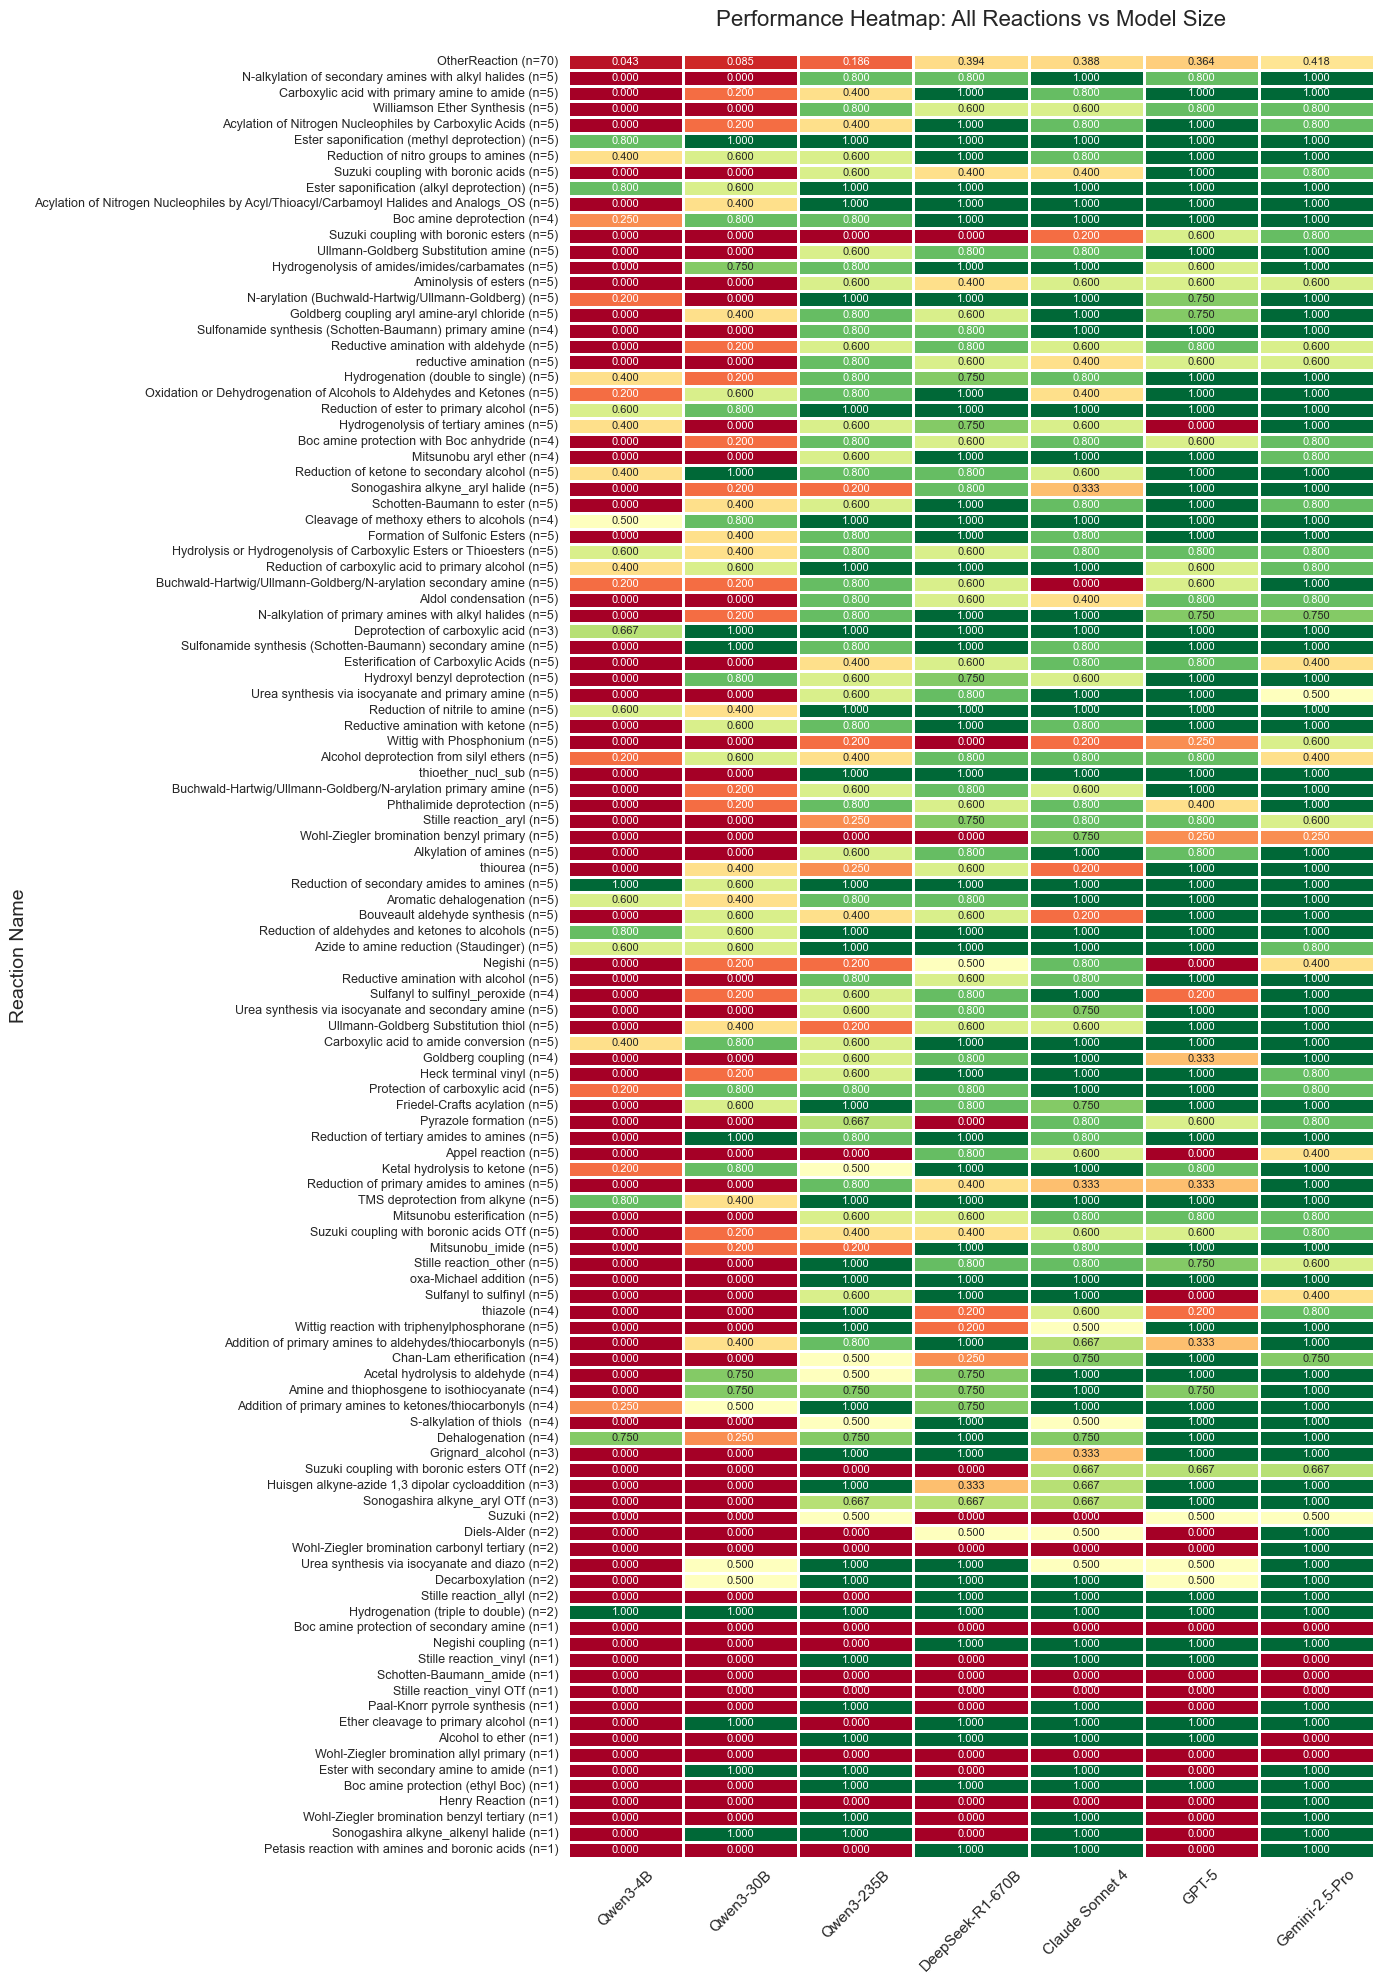

In [42]:
# Create the heatmap with the same style as before
plt.figure(figsize=(14, 20))  # A4-like proportions

# Reorder columns to include DeepSeek
# column_order = ['Qwen3-4B', 'Qwen3-30B', 'Qwen3-235B', 'DeepSeek-R1-670B']
column_order = list(all_models.values())
heatmap_data = heatmap_data.reindex(columns=column_order)
## Sort rows by using the order variable and matching it to the rxn_insight_name column
heatmap_data = heatmap_data.reindex(order)

# Sort by reaction name
# sorted_reactions = sorted(heatmap_data.index)
# heatmap_data = heatmap_data.reindex(sorted_reactions)

## Make sure that missing values are shown as 0.0
heatmap_data = heatmap_data.fillna(0.0)

# Get sample counts for each reaction from the first model's data
reaction_sample_counts = {}
for rxn_name in order:
    if rxn_name == "OtherReaction":
        category_name = "other_reaction"
    else:
        category_name = f"reaction_{rxn_name}"
    
    # Get sample count from first available model (qwen3_4b)
    reaction_row = qwen3_4b[qwen3_4b['category'] == category_name]
    if not reaction_row.empty:
        sample_count = reaction_row['total_samples'].iloc[0]
        reaction_sample_counts[rxn_name] = sample_count

# Create y-tick labels with sample counts
y_labels_with_counts = [f"{rxn} (n={reaction_sample_counts.get(rxn, 0)})" for rxn in order]

# Create heatmap with larger cells - remove color legend
ax = sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar=False,  # Remove color legend
            linewidths=1, square=False, 
            annot_kws={'size': 8},  # Smaller font for 4 columns
            yticklabels=True)  # Ensure y-tick labels are shown

# Properly align y-tick labels with heatmap cells and add sample counts
# ax.set_yticks([i + 0.5 for i in range(len(sorted_reactions))])  # Center ticks in cells
ax.set_yticklabels(y_labels_with_counts, fontsize=9, rotation=0)

plt.title('Performance Heatmap: All Reactions vs Model Size', fontsize=16, pad=20)
plt.ylabel('Reaction Name', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45, fontsize=11)  # Rotate x-axis labels for better fit
plt.tight_layout()
plt.savefig(os.path.join(pdf_save_folder_path, 'performance_heatmap_all_reactions.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [43]:
heatmap_data

Model Size,Qwen3-4B,Qwen3-30B,Qwen3-235B,DeepSeek-R1-670B,Claude Sonnet 4,GPT-5,Gemini-2.5-Pro
rxn_insight_name,,,,,,,
OtherReaction,0.042857,0.084507,0.185714,0.393939,0.38806,0.363636,0.41791
N-alkylation of secondary amines with alkyl halides,0.000000,0.000000,0.800000,0.800000,1.00000,0.800000,1.00000
Carboxylic acid with primary amine to amide,0.000000,0.200000,0.400000,1.000000,0.80000,1.000000,1.00000
Williamson Ether Synthesis,0.000000,0.000000,0.800000,0.600000,0.60000,0.800000,0.80000
Acylation of Nitrogen Nucleophiles by Carboxylic Acids,0.000000,0.200000,0.400000,1.000000,0.80000,1.000000,0.80000
...,...,...,...,...,...,...,...
Boc amine protection (ethyl Boc),0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,1.00000
Henry Reaction,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.00000
Wohl-Ziegler bromination benzyl tertiary,0.000000,0.000000,1.000000,0.000000,1.00000,0.000000,1.00000
